In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from diffusers.utils import make_image_grid
from torchvision.transforms.functional import to_pil_image, to_tensor

from optimize_inverted_ddim import *

/USERSPACE/lukovdg1/venvs/sd3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_ID = "stabilityai/stable-diffusion-2-1-base"
DEVICE = torch.device("cuda")

In [4]:
pipe, forward_scheduler, inverse_scheduler = load_pipe(modelid=MODEL_ID, device=DEVICE)
# # Load the pre-trained Stable Diffusion 2.1 model from Hugging Face
# pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID,
#                                                scheduler=DDIMScheduler.from_pretrained(MODEL_ID, subfolder='scheduler', torch_dtype=torch.float32),  # DPMSolverMultistepScheduler.from_pretrained(...)
#                                                safety_checker=None,
#                                                torch_dtype=torch.float32).to(DEVICE)

# forward_scheduler = pipe.scheduler
# inverse_scheduler = DDIMInverseScheduler.from_pretrained(MODEL_ID, subfolder='scheduler', torch_dtype=torch.float32)  # DPMSolverMultistepInverseScheduler.from_pretrained(...)


Loading pipeline components...:  50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


In [18]:
PROMPT = "a black and white photograph of a cow"
# "A futuristic city skyline at sunset"
NUM_INFERENCE_STEPS = 50
GUIDANCE_SCALE  = 7.5

RESOLUTION = 512
LATENT_SHAPE = (1, 4, RESOLUTION // 8, RESOLUTION // 8)

 46%|████▌     | 23/50 [00:02<00:03,  8.80it/s]

100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


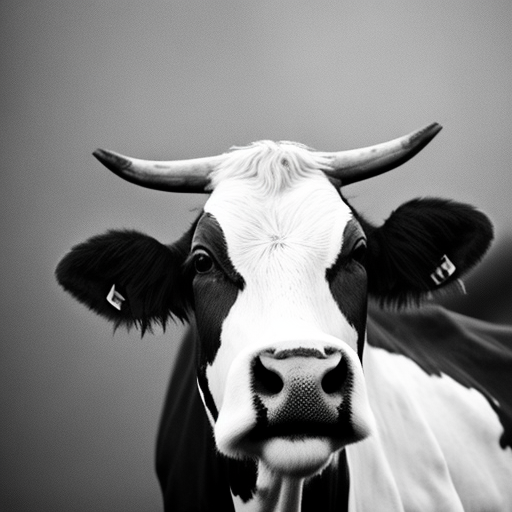

In [19]:
pipe.scheduler = forward_scheduler
# Generate an image
image = pipe(PROMPT,
           num_inference_steps=NUM_INFERENCE_STEPS,
           guidance_scale=GUIDANCE_SCALE).images[0]
display(image)

In [20]:
# need to get z0 first
image_pt = 2. * to_tensor(image).to(DEVICE)[None] - 1.
print(image_pt.shape)
posterior = pipe.vae.encode(image_pt).latent_dist
z0 = posterior.mean * pipe.vae.config.scaling_factor  # * 0.18215 for SD 15, 21, Mitusa...
z0 = z0.to("cuda")

 # set to inverse scheduler
pipe.scheduler = inverse_scheduler

# invert z0 to zT
zT_retrieved = pipe(latents=z0,
                    num_inference_steps=NUM_INFERENCE_STEPS,
                    prompt=[""] * z0.shape[0],
                    negative_prompt="",
                    guidance_scale=1.,
                    width=RESOLUTION,
                    height=RESOLUTION,
                    output_type='latent',
                    return_dict=False,
                    )[0]




torch.Size([1, 3, 512, 512])


  8%|▊         | 4/50 [00:00<00:03, 15.26it/s]

100%|██████████| 50/50 [00:03<00:00, 15.18it/s]


In [21]:

# zT_retrieved = wiggle_latents(zT_retrieved)

In [22]:
zT_retrieved.dtype, zT_retrieved.device

(torch.float32, device(type='cuda', index=0))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


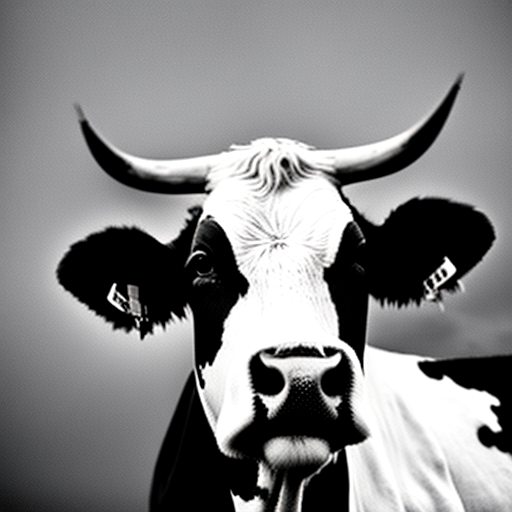

In [23]:
pipe.scheduler = forward_scheduler
# reconstruct image from inversion
image_recons = pipe(PROMPT,
           num_inference_steps=NUM_INFERENCE_STEPS,
           guidance_scale=GUIDANCE_SCALE,
           latents=zT_retrieved).images[0]
display(image_recons)


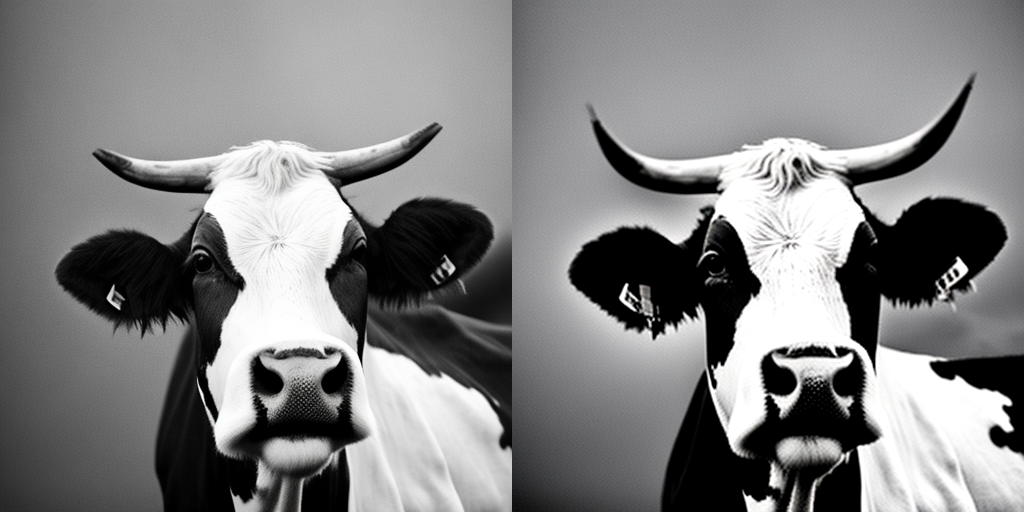

In [24]:
display(make_image_grid([image, image_recons], 1, 2))

In [10]:
# need to get z0 first
image_pt = 2. * to_tensor(image_recons).to(DEVICE)[None] - 1.
print(image_pt.shape)
posterior = pipe.vae.encode(image_pt).latent_dist
z0 = posterior.mean * pipe.vae.config.scaling_factor  # * 0.18215 for SD 15, 21, Mitusa...
z0 = z0.to("cuda")

 # set to inverse scheduler
pipe.scheduler = inverse_scheduler

# invert z0 to zT
zT_reretrieved = pipe(latents=z0,
                    num_inference_steps=NUM_INFERENCE_STEPS,
                    prompt=[""] * z0.shape[0],
                    negative_prompt="",
                    guidance_scale=1.,
                    width=RESOLUTION,
                    height=RESOLUTION,
                    output_type='latent',
                    return_dict=False,
                    )[0]

torch.Size([1, 3, 512, 512])


100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


100%|██████████| 200/200 [00:23<00:00,  8.69it/s]


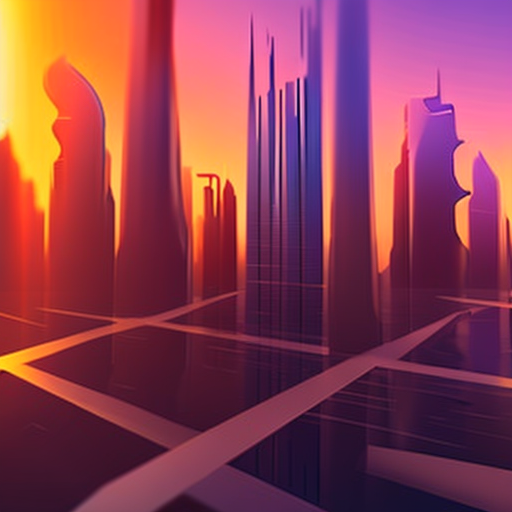

In [11]:
pipe.scheduler = forward_scheduler
# reconstruct image from inversion
image_rerecons = pipe(PROMPT,
           num_inference_steps=NUM_INFERENCE_STEPS,
           guidance_scale=GUIDANCE_SCALE,
           latents=zT_reretrieved).images[0]
display(image_recons)


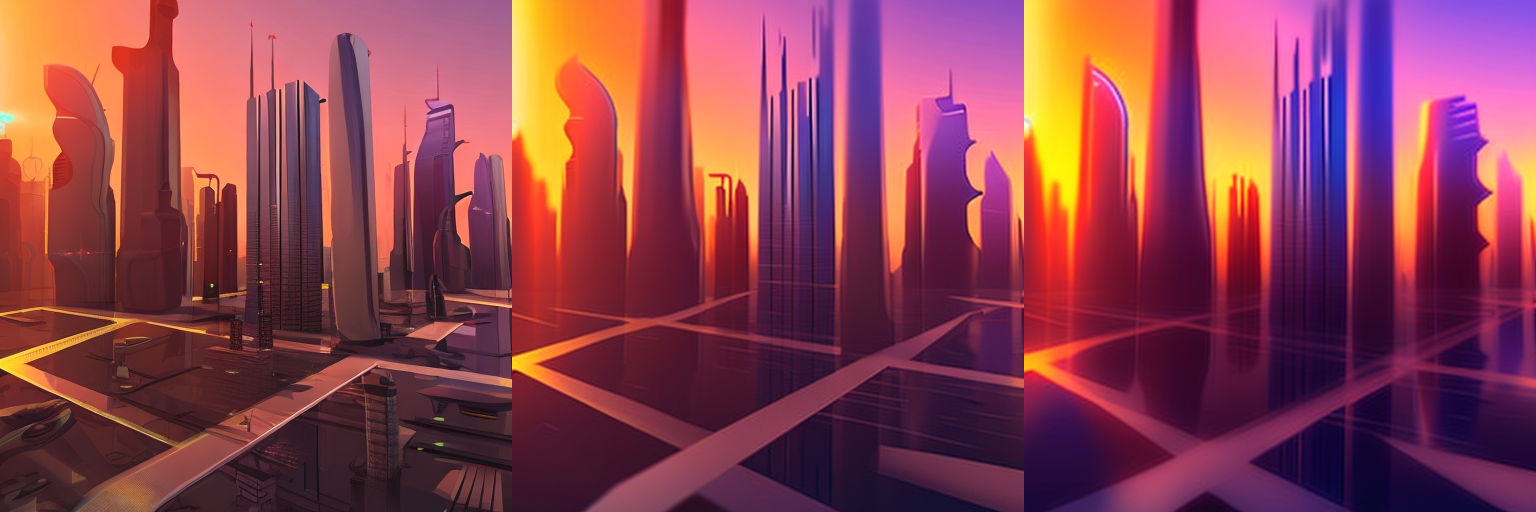

In [12]:
display(make_image_grid([image, image_recons, image_rerecons], 1, 3))